# Fine tuning and Custom realization of an image classifier
### CVIP exam project by Casadei Edoardo and Gaspari Riccardo

### The key idea of the project
The first goal of the project was the fine tuning of a pretrained model to realize an image classifier. After having obtained sufficient results on the ResNet50 model we decided to challenge ourselves in the implementation of a simple model, suitable to classify our specific data-set. In this project we chose a data-set from Kaggle that consists in approximately 2300 images of 10 different feline species (https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification).

### The steps of the project
$1$) Setup of the environment

$2$) Data preparation

$3.1$) Fine tuning of ResNet50 (explained in the other notebook)

$3.2$) Development and training of the custom model (this notebook)

$4$) Evaluation and comparison of the two models

<p align="center">
  <img src="image.jpg" width="768" class="center">
</p>


    
## 1) Setup of the environment

In the project we imported the following necessary libraries:
* **Os**
* **Numpy**
* **Tensorflow**
* **Matplotlib**
* **OpenCV**
* **Scikit Learn**

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Fixed random seed for repeatability.
seed = 21
tf.random.set_seed(seed)
np.random.seed(seed)

#### Check the environment versions and the GPU usage
Given the fact that we worked on Windows laptops, in order to exploit the GPU for the training process we couldn't use the latest versions of Python and Tensorflow due to conficts between these versions and the usage of GPUs on native Windows PCs. As a consequence we decided to downgrade to python $3.8.10$ and TF $2.4$ to use an RTX 4080 laptop version available from one of our laptops.

In [2]:
import sys
# Check the versions of the environment
print("Python version")
print(sys.version)
print("TensorFlow version")
print(tf.__version__)
print("Keras version")
print(keras.__version__)


Python version
3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
TensorFlow version
2.4.0
Keras version
2.4.0


In [3]:
# Check the usage of the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14301986060116665235
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10531211136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13628999446599467142
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
]


## 2) Data preparation

For convenient mapping we first assign labels to the name of the classes, then we set a default image size for the images to be resized while being loaded into the images array.

As will be shown in the code, the labeling step won't be used in the loading process; indeed a label is directly assigned without the need of the class name. However, it will be necessary for the final steps of the notebook.

It's paramount to observe that the labels mapping of the very next step is coherent with the direct labels assigning of the loading step (the classes are in alphabetic order).

In [4]:
# Labels mapping
labels = {
            0 : "African Leopard",
            1 : "Caracal",
            2 : "Cheetah",
            3 : "Clouded Leopard",
            4 : "Jaguar",
            5 : "Lions",
            6 : "Ocelot",
            7 : "Puma",
            8 : "Snow Leopard",
            9 : "Tiger"
        }

# Set a default image size
image_size = (224, 224)

#### Data loading
The input data are organized as an ordinary DataSet, with folders for each class and *.jpg* images in each one.

An additional resize step is required to be sure that the images are all the same size ($224\times224$ pixels).


In [5]:
def load_and_resize_image(image_path, size):

    # Load the image
    img = cv2.imread(image_path)
    
    # Resize the image
    img_resized = cv2.resize(img, size)
    
    # Convert the image to a numpy array and return it
    return np.array(img_resized)


In [6]:
def load_data(data_dir):
    
    # Get the list of class directories
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Initialize lists to hold images and labels
    x = []
    y = []
    
    (img_width, img_height) = image_size
    
    # Iterate over the class directories
    for i, class_dir in enumerate(class_dirs):
        # Get the list of image files in this directory
        image_files = [f for f in os.listdir(os.path.join(data_dir, class_dir))]
    
        # Iterate over the image files
        for image_file in image_files:
            # Define the path to the image file
            image_path = os.path.join(data_dir, class_dir, image_file)
            
            # Load and resize the image
            img = load_and_resize_image(image_path, (img_width, img_height))
    
            x.append(img)
            y.append(i)

    x = np.array(x)
    y = np.array(y)
    # Print the number of elements of the DataSet
    print(f"{x.shape[0]} images loaded")
    
    # Convert lists to numpy arrays
    return (x, y)

#### Data splitting

In this step we load the Training Set, Validation Set and Test Set from the DataSet default folders, and we check the range of the images before normalizing them.


In [7]:
(X_train, y_train) = load_data('C:/Users/ricig/Desktop/archive_cats/train')
(X_test, y_test) = load_data('C:/Users/ricig/Desktop/archive_cats/test')
(X_val, y_val) = load_data('C:/Users/ricig/Desktop/archive_cats/valid')

print(f"The Training images are in the range [{X_train.min()},{X_train.max()}].")
print(f"The Test images are in the range [{X_test.min()},{X_test.max()}].")
print(f"The Validation images are in the range [{X_val.min()},{X_val.max()}].")

print(f"The Training Set contains {X_train.shape[0]} elements")
print(f"The Validation Set contains {X_val.shape[0]} elements")
print(f"The Test Set contains {X_test.shape[0]} elements")

2337 images loaded
50 images loaded
50 images loaded
The Training images are in the range [0,255].
The Test images are in the range [0,255].
The Validation images are in the range [0,255].
The Training Set contains 2337 elements
The Validation Set contains 50 elements
The Test Set contains 50 elements


#### Data Augmentation

Data Augmentation is applied to the Training Set in order to increase the number of data for the training procedure; for this means we performed a simple step of random contrast, random horizontal flip and random translation, quadrupling the training images.

For this step we exploited the default *DataSet* object of Keras libraries, then applying the augmentation with some Keras preprocessing functions. The reason for that is that we encountered several memory issues (RAM overflow) while applying the augmentation on a normal numpy array. By this viewpoint, computing the augmentation to the *DataSet* object seemed to be a more memory efficient way of performing it.

Actually, we could have used the *DataSet* object for the whole training, but we didn't use it for coherence with what done in the lab classes.

In [8]:

# Create a data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])

def augment_image(img):

    img = tf.expand_dims(img, axis=0)

    # Apply the data augmentation
    img = data_augmentation(img)

    img = tf.squeeze(img, axis=0)

    return img

# Apply the augmentation function to each image in X_train (4 times)
X_train = [augment_image(image) for _ in range(4) for image in X_train]
y_train = [label for _ in range(4) for label in y_train]

X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"The Augmented Training Set contains {X_train.shape[0]} elements")
print(y_train.shape[0])
print(f"The range of the X_train's images is [{X_train.min()},{X_train.max()}].")

The Augmented Training Set contains 9348 elements
9348
The range of the X_train's images is [0,255].


#### Data Normalization
The input data are noramlized in such a way that they lie in the same interval, in order to get a more efficient learning and to uniform metrics and losses based on similarities.

In [9]:
# Data Normalization
X_train = X_train.astype('float') / X_train.max()
print(f"The new range of the X_train's images is [{X_train.min()},{X_train.max()}].")
X_val = X_val.astype('float') / X_val.max()
print(f"The new range of the X_val's images is [{X_val.min()},{X_val.max()}].")
X_test = X_test.astype('float') / X_test.max()
print(f"The new range of the X_test's images is [{X_test.min()},{X_test.max()}].")

The new range of the X_train's images is [0.0,1.0].
The new range of the X_val's images is [0.0,1.0].
The new range of the X_test's images is [0.0,1.0].


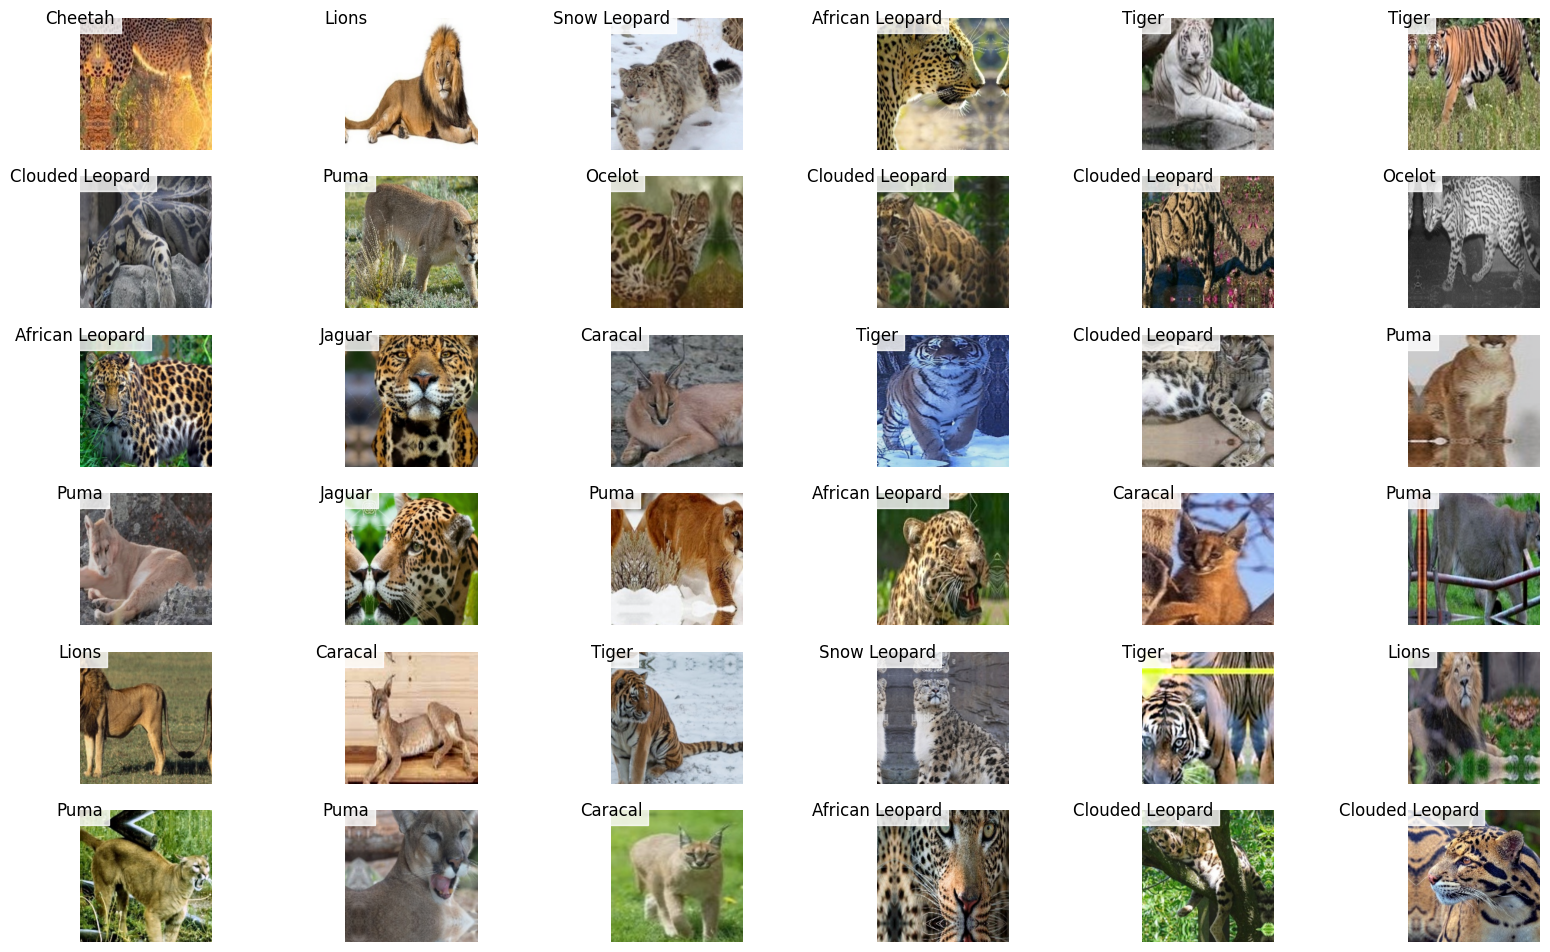

In [10]:
# Check some images
fig, ax = plt.subplots(6, 6, figsize=(20, 12))
ax = ax.ravel()

for i in range(36):
    rand_idx = np.random.randint(0, X_train.shape[0])

    ax[i].set_axis_off()
    
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(X_train[rand_idx].astype(np.float32), cv2.COLOR_BGR2RGB)

    ax[i].imshow(img_rgb, cmap = "gray")
    
    # Print y_train value on top of the image
    ax[i].text(0.5, 0.5, str(labels[y_train[rand_idx]]), fontsize=12, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


## $3.2$) Development and training of the custom model

Building this model, we tried many layer configurations and number of parameters, testing different layer types and kernel sizes in order to achieve the most performing CNN (at least for our abilities).

Here is reported the final model used for the training; we are going to briefly introduce the key functions used in our solution:
* **Conv2D**: it's a 2D correlation (plus a bias term) between the input tensor and a defined number of kernels (in our case $64$, $128$, $256$) of $(3\times3)$ size. The output of the Conv2D layer is a tensor of *num_filters* channels and size equal to
  $$
  H_{out}=H_{in}-2(H_k-1)
  $$
  $$
  W_{out}=W_{in}-2(W_k-1)
  $$
with $H$ and $W$ the heights and widths of the input and output features and the kernel.<br>The activation parameter introduces a non-linearity, necessary because an affine neural network is not able to achieve good results. The standard choice for the most recent applications is the *ReLU* function, expressed as
  $$
  ReLU(a)=max(0, a)
  $$
We decided to avoid the use of any type of padding to avoid the insertion of unuseful informations of the image.
* **MaxPooling2D**: it's a Pooling layer that reduces the size of $H_{in}$ and $W_{in}$ depending on the *pool_size* (chosen symmetric, in our case $2\times2$, so they are reduced by a factor of $2$), replacing for each *pool_size* inputs the maximum of them. The role of Pooling layers is to shrink the input size to be able to capture bigger and bigger patterns of the image without having too many layers, increasing the receptive field.
* **Dropout**: it's a simple and effective regularization method used to reduce overfitting and improve generalization error in deep neural networks. Dropout works by randomly "dropping out" or ignoring certain nodes in the network during training, and its argument is the percentage of neurons "switched off" at each parameters update during training time.
* **Flatten**: it is used to unroll the input tensor in a single array, put between the Feature Maps and the chain of FCL of a classical CNN.
* **Dense**: it represents a FCL; the arguments are the size of the output array and the activation function. In case of a chain of FCL, the inner layers might have an arbitrary array size as well as different types of activation functions, with the same role as in the Conv2D, applied after the linear map (ReLU is the standard choice). However, the last layer's arguments always consist in the number of classes of our specific application followed by the *Softmax* activation function, which returns the probabilities of an image to belong to a specific class. In our case, a single FCL was introduced in the model, but many other configurations were tested always returning worse results.

In the workflow that brought us to this model, we tried to respect the usual layering norms (at least for our knowledge). In particular:
1) progressively increase the *num_filters* of the Conv2D layers: indeed, the first layers capture very small features of the image, such as borders and textures; going more deeply into the network, bigger and bigger features can be combined together, so usually these are the most informative steps. The particular configuration of the number of filters used is due to some considerations about the "scale" of the important features especially for some classes (e.g. jaguar and leopard) that suggested us to increase the number of filters for medium-size features. After many attempts, this configuration gave us the best results.
3) keep the *pool_size* constant for the whole model: MaxPooling2D is used to downgrade the size of the input without losing too many relevant informations; a usual size for the pooling is $(2,2)$.
4) as well as for the *num_filters*, often the *kernel_size* of the Conv2D layers is progressively decreased going deeper into the network. Bigger kernels in the first layers allow to capture low-level features on a bigger area of the input; going deeper into the network, smaller kernels can combine these low-level characteristics to get higher-level features, taking advantage of an higher receptive field.
5) Dropout balancing: we tried many percentages in the range $[0.15,\,0.5]$, tracking the training accuracy and the validation loss; an higher Dropout percentage increase the generalization ability of the network, avoiding overfitting, but usually requires a larger model to be able to reach high accuracy.

In [11]:
num_classes = 10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 256)     147712    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)      

## Final settings and training

The last hyperparameters to set are:
* **Optimizer**: Adam is the most used optimizer for image classification tasks; in the process we tested SGD, claimed to be better for small dataset, with sparse results.
* **Learning Rate**: $1e-3$ is a standard value for the Adam optimizer; again, we played with the parameter with very bad results.
* **Loss Function**: SparseCategoricalCrossentropy is the standard choice for multi-class image classifiers.
* **Batch Size**: we did some trials with 16, 32 and 64, but we always got worse results so we sticked to 128.

In the end, for the training step we decided to run 200 epochs to have a clearer understanding of the *val_loss* and *val_accuracy* trends, eventually manually stopping the training and calling back the minimum-loss / maximum-accuracy epoch for the final evaluation on the Test Set.

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/Users/ricig/Desktop/Callbacks/save_at_{epoch}.keras")
]

# Set the hyperparameters and the profiling functions
opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()

model.compile(loss = loss_fcn, 
              optimizer = opt,
              metrics = ["accuracy"])

batch_size = 128
epochs = 200

history = model.fit(X_train,
          y_train,
          batch_size = batch_size,
          callbacks=callbacks,
          epochs = epochs,
          validation_data = (X_val, y_val));

Epoch 1/200
74/74 [==============================] - 47s 378ms/step - loss: 2.2432 - accuracy: 0.1288 - val_loss: 1.8279 - val_accuracy: 0.3800
Epoch 2/200
74/74 [==============================] - 17s 233ms/step - loss: 1.8481 - accuracy: 0.2686 - val_loss: 1.5296 - val_accuracy: 0.4400
Epoch 3/200
74/74 [==============================] - 18s 241ms/step - loss: 1.6317 - accuracy: 0.3565 - val_loss: 1.3656 - val_accuracy: 0.4600
Epoch 4/200
74/74 [==============================] - 18s 243ms/step - loss: 1.4278 - accuracy: 0.4421 - val_loss: 1.2340 - val_accuracy: 0.5200
Epoch 5/200
74/74 [==============================] - 18s 240ms/step - loss: 1.2698 - accuracy: 0.5005 - val_loss: 2.0402 - val_accuracy: 0.4400
Epoch 6/200
74/74 [==============================] - 18s 237ms/step - loss: 1.3968 - accuracy: 0.4739 - val_loss: 0.9694 - val_accuracy: 0.6200
Epoch 7/200
74/74 [==============================] - 18s 239ms/step - loss: 1.0290 - accuracy: 0.5936 - val_loss: 1.0655 - val_accuracy:

KeyboardInterrupt: 

## 4.1) Model Evaluation

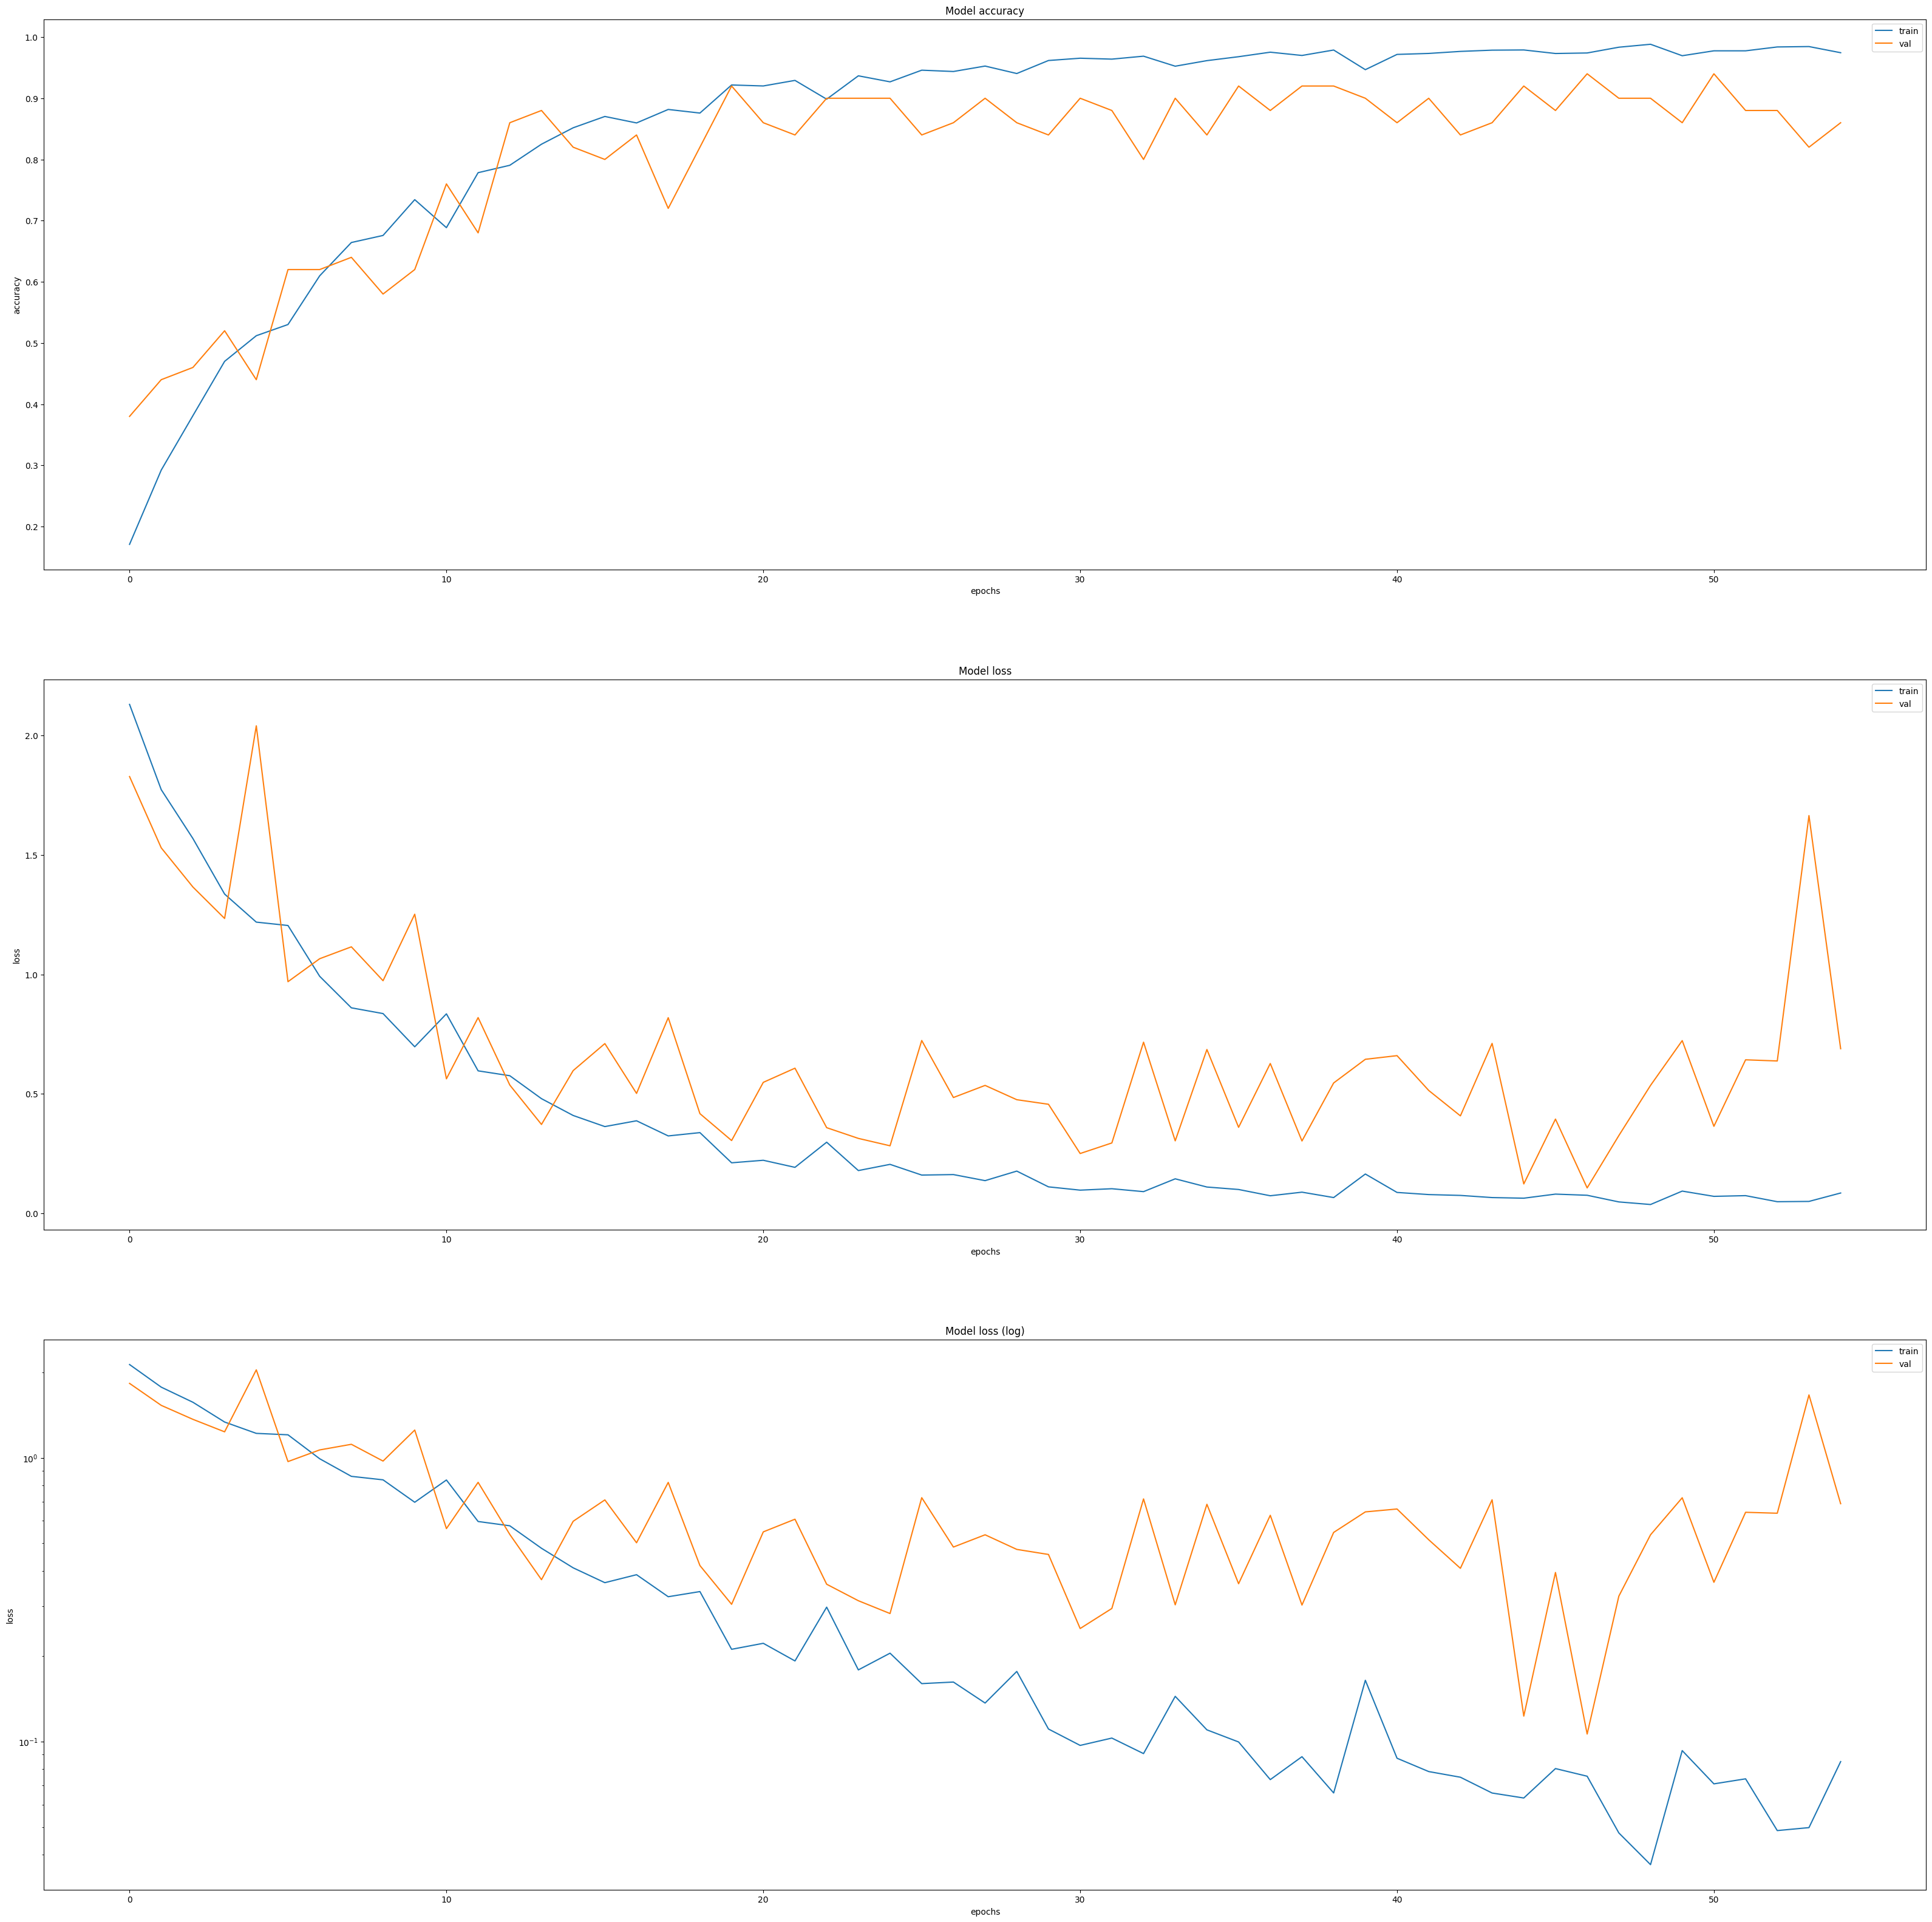

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(40, 40))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Logarithmic loss
metric = "loss"
ax[2].plot(model.history.history[metric])
ax[2].plot(model.history.history["val_" + metric])
ax[2].set_title("Model {} (log)".format(metric))
ax[2].set_xlabel("epochs")
ax[2].set_ylabel(metric)
ax[2].legend(["train", "val"])
ax[2].set_yscale("log")

plt.show()

In [14]:
# (Eventually) reload the minimum val_loss Epoch
model = tf.keras.models.load_model("C:/Users/ricig/Desktop/Callbacks/save_at_47.keras")

In [15]:
# Inference on the Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')


2/2 [==============================] - 5s 2s/step - loss: 0.3735 - accuracy: 0.9200
Test loss: 0.37354764342308044
Test accuracy: 0.9200000166893005


* Inspecting the prediction with the *predict()* method

In [16]:
pred = model.predict(X_test)

* Check the correctness of the prediction summing for all the classes

In [17]:
print(pred.sum(axis=-1))

[0.99999994 1.         0.9999999  0.99999994 1.0000001  1.
 1.         1.         1.         1.0000001  1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99999994 1.         1.         0.99999994
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         0.99999994 0.99999994 1.
 1.0000001  1.         1.         1.         1.         1.
 1.         1.0000001  1.         1.         1.         1.
 1.         1.        ]


* Assign the predicted label as the maximum probability

In [18]:
pred = np.argmax(pred, axis = -1)
pred

array([0, 0, 0, 0, 0, 1, 7, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 4,
       4, 4, 4, 5, 5, 5, 5, 7, 6, 6, 6, 6, 9, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int64)

* Check the prediction with some elements of the Test Set

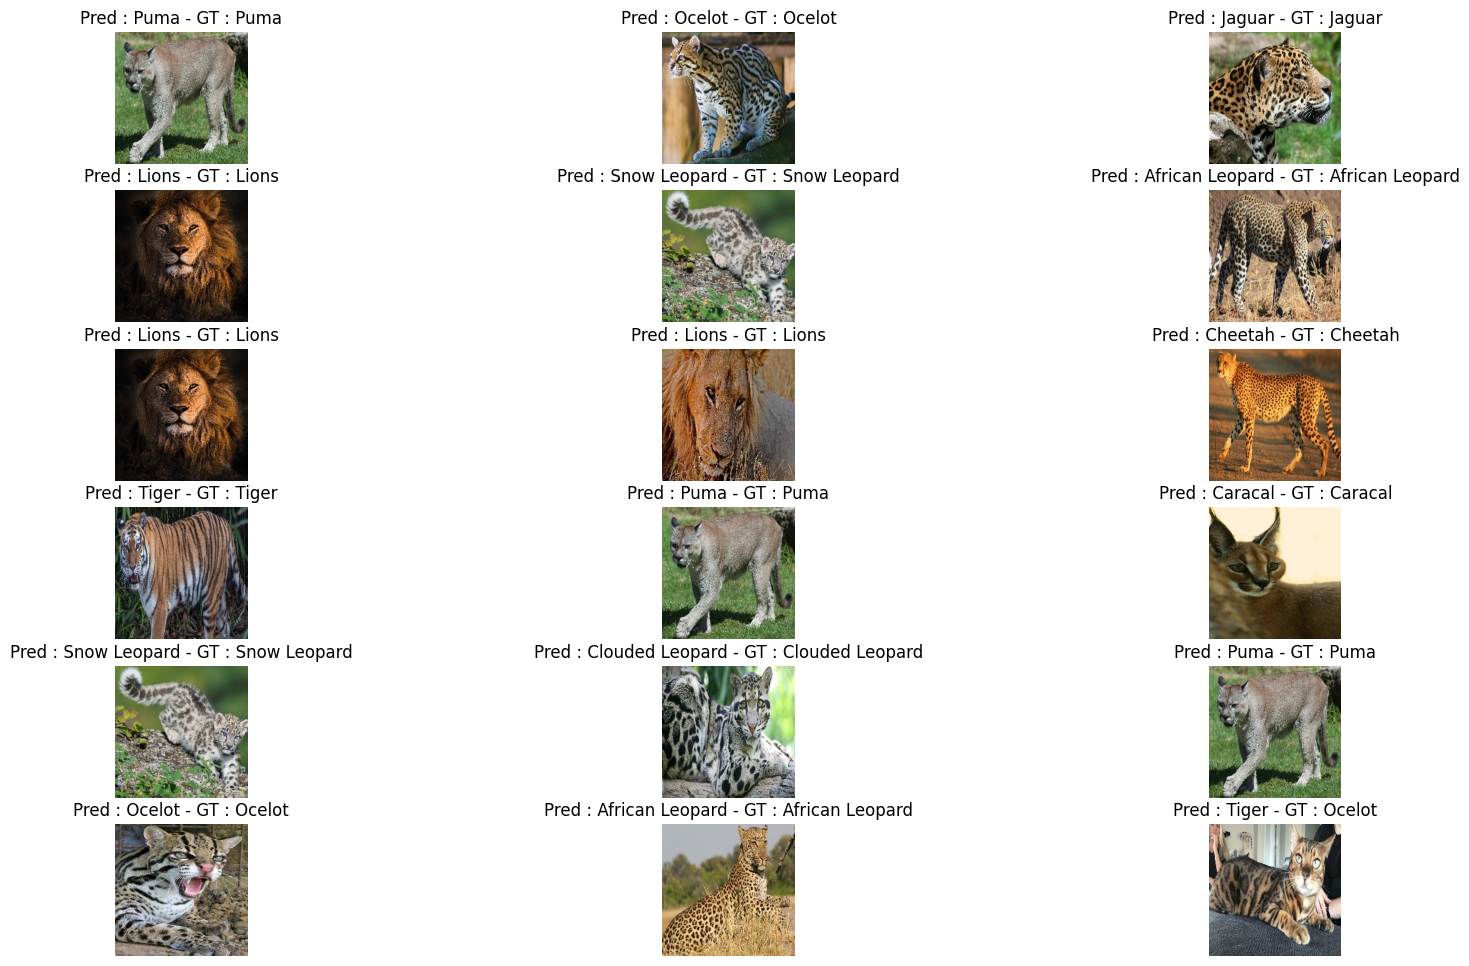

In [21]:
fig, ax = plt.subplots(6, 3, figsize=(20, 12))
ax = ax.ravel()

for i in range(18):
    rand_idx = np.random.randint(0, X_test.shape[0])

    ax[i].set_axis_off()
    
    # Convert the image to 8-bit unsigned integers
    img_8bit = cv2.normalize(X_test[rand_idx], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2RGB)
    
    ax[i].set_title(f"Pred : {labels[pred[rand_idx]]} - GT : {labels[y_test[rand_idx]]}")
    ax[i].imshow(img_rgb, cmap = "gray")


#### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of an image classifier on a set of test data for which the true values are known. It effectively summarizes the performance of a classification algorithm.

An element in the position $(i,j)$ represents the probability to classify an image of the $i$-th class into the $j$-th class; so the sum of the elements of a row will always return 1.
Obviously, in an effective model the most of the probability is contained in the main diagonal, which represents the correct prediction, while the other values are sought to be very small (ideally $\approx 0$).

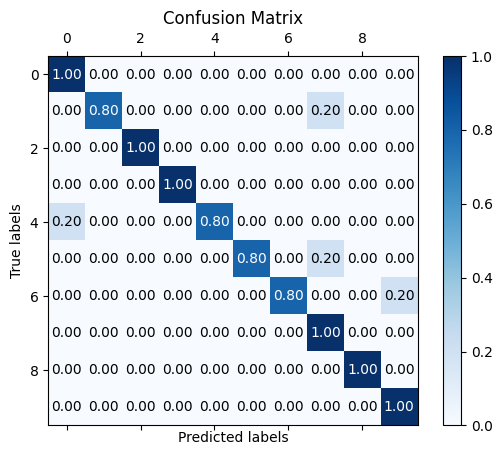

In [20]:
from sklearn.metrics import confusion_matrix

# Use scikit-learn's confusion_matrix function
cm = confusion_matrix(y_test, pred, normalize='true')

# Create a figure and an axis
fig, ax = plt.subplots()

# Create a color map
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Create a color bar
fig.colorbar(cax)

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Add text annotations to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Use white color for the diagonal and black for others
        color = 'white' if i == j else 'black'
        ax.text(j, i, f'{cm[i, j]:.2f}', ha='center', va='center', color=color)

# Show the plot
plt.show()


## 4.2) Comparison between ResNet50 and the custom model

| Metric | ResNet50 | Custom |
|--------|----------|--------|
| accuracy | 0.9800  | 0.9200  |
| loss | 0.0781   | 0.3735  |
| trainable parameters | 23,555,082   | 1,370,390 |


The ResNet50 achieved higher (test) accuracy and loss compared to the custom model, but of course at the price of many more parameters and only thanks to the pretraining with *imagenet*, otherwise it would have probably overfitted.

On the other side, the custom model achieved fairly good results with a much simpler network.
